<a href="https://colab.research.google.com/github/mamirandamorante/SVHN/blob/main/Image_Classifier_using_SVHN_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project
## Image classifier for the SVHN dataset

Image classifier for the SVHN dataset
In this notebook, I create a neural network that classifies real-world images digits. I will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all. SVHN is obtained from house numbers in Google Street View images.

Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [1]:
#Import Libraries
import tensorflow as tf
import random
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Connect to Google Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Load the dataset from Google drive folder

train = loadmat('/content/gdrive/MyDrive/path/to/train_32x32.mat')
test = loadmat('/content/gdrive/MyDrive/path/to/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries.
* Select 10 random sample of images and corresponding labels from the dataset and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel.
* Select 10 random sample of the grayscale images and corresponding labels from the dataset and display them in a figure.

In [4]:
#Extract the training and testing images and labels
X_train = train['X']
y_train = train['y']
X_test = test['X']
y_test = test['y']

#Take a look at the traiing and testing shape

print("Training Set", X_train.shape, y_train.shape)
print("Testing Set", X_test.shape, y_test.shape)

Training Set (32, 32, 3, 73257) (73257, 1)
Testing Set (32, 32, 3, 26032) (26032, 1)


In [5]:
# Calculate the total number of images
num_images = X_train.shape[3] + X_test.shape[3]
print("Total Number of Images in the dataset:", num_images)

Total Number of Images in the dataset: 99289


In [6]:
#Convert to Float and Normalize the train and test images

X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

y_train = y_train.astype('int64')
y_test = y_test.astype('int64')

X_train = X_train / 255.0
X_test = X_test / 255.0

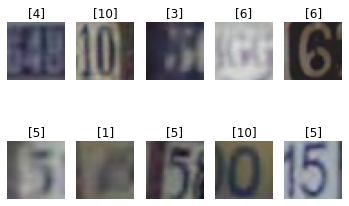

In [7]:
# Plot 10 training set images and its labels
for i in range(10):
    elde = random.randint(0,1000)
    plt.subplot(2,5,i+1)
    plt.title(str(y_train[elde]), fontsize=12) 
    plt.imshow(X_train[:,:,:,elde]) 
    plt.axis("off") 
plt.show()

In [8]:
#Convert training and test image sets from RGB to grayscale
X_train = np.average(X_train,axis = 2) #Average over axis 2 -> Channel (H,W,C,S)
X_test = np.average(X_test,axis = 2) #Average over axis 2 -> Channel (H,W,C,S)
print("Training Set", X_train.shape, y_train.shape)
print("Testing Set", X_test.shape, y_test.shape)

Training Set (32, 32, 73257) (73257, 1)
Testing Set (32, 32, 26032) (26032, 1)


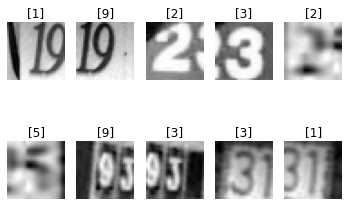

In [9]:
# Plot 10 training set images and its labels
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(str(y_train[i]), fontsize=12) 
    plt.imshow(X_train[:,:,i], cmap=plt.get_cmap('gray'))
    plt.axis("off") 
plt.show()

In [10]:
#Move axis from (H,W,C,S) to (S,H,W,C). Channel = 1 after converting from RGB to Grayscale
X_train_mlp = np.moveaxis(X_train, -1, 0)
X_test_mlp = np.moveaxis(X_test, -1, 0)
X_train_mlp =X_train_mlp[..., np.newaxis] #Add channel = 1
X_test_mlp = X_test_mlp[..., np.newaxis] # Add channel = 1
print("Training Set", X_train_mlp.shape, y_train.shape)
print("Testing Set", X_test_mlp.shape, y_test.shape)

Training Set (73257, 32, 32, 1) (73257, 1)
Testing Set (26032, 32, 32, 1) (26032, 1)


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API using the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer have a 10-way softmax output. 
* Compile and train the model, making use of both training and validation sets during the training run.
* The model tracks Accuracy metric, and use two callbacks during training EarlyStopping and ModelChecking
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [11]:
#Definition of Callbacks
# 1) ModelChecking: Save Weights of best accuracy model 
# 2) EarlyStopping: when accuracy on validation dataset has not improve after 8 epochs
def get_checkpoint_best_only_cnn():
    checkpoint_best_only_path_cnn = 'checkpoints_best_only_cnn/checkpoint'
    checkpoint_best_only_cnn = ModelCheckpoint(filepath = checkpoint_best_only_path_cnn,
                                          save_weights_only=True,
                                          save_best_only=True,
                                          monitor = 'val_accuracy',
                                          verbose =1)
    return checkpoint_best_only_cnn

def get_early_stopping_cnn():
    callback_cnn = tf.keras.callbacks.EarlyStopping(patience=8)
    return callback_cnn

In [12]:
#CNN Architecture: Conv->Batch->Conv->MaxPool->Dropout->Conv->MaxPool->Dropout->Conv->Batch->Conv->MaxPool->Dropout->Flatten->Dropout-Dense
#Adam optimizer learning rate 0.001, sparse_categorical_crossentropy
def get_model_cnn(input_shape):
    cnn_model = Sequential([
        Conv2D(filters=32, input_shape=(32, 32, 1), kernel_size=(3, 3), activation='relu', padding ='same', name='conv_1'),
        BatchNormalization(),
        Conv2D(filters=32, kernel_size=(3, 3), padding ='same', activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(2, 2), name='pool_1'), 
        Dropout(0.3), 
        Conv2D(filters=64, kernel_size=(3, 3), padding ='same', activation='relu', name='conv_3'),
        MaxPooling2D(pool_size=(2, 2), name='pool_2'),  
        Dropout(0.3),  
        Conv2D(filters=128, kernel_size=(3, 3), padding ='same', activation='relu', name='conv_4'),
        BatchNormalization(),
        Conv2D(filters=128, kernel_size=(3, 3), padding ='same', activation='relu', name='conv_5'),
        MaxPooling2D(pool_size=(2, 2), name='pool_3'),  
        Dropout(0.3),
        Flatten(name='flatten'),
        Dropout(0.4),  
        Dense(units=11, activation='softmax', name='dense_1')
    ])  
    optimizer = tf.keras.optimizers.Adam(lr=1e-3, amsgrad=True)
    cnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return cnn_model

In [13]:
cnn_model = get_model_cnn(X_train_mlp[0].shape)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 32)        9248      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 16, 16, 64)        18496     
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 8, 8, 64)          0

In [14]:
checkpoint_best_only_cnn = get_checkpoint_best_only_cnn()
early_stopping_cnn = get_early_stopping_cnn()

In [15]:
#Train the model 75 epochs with a batch size of 128. Validation test is split 15%
callbacks_cnn=[checkpoint_best_only_cnn,early_stopping_cnn]
history = cnn_model.fit(X_train_mlp, y_train, epochs=75, batch_size = 128, validation_split=0.15,verbose=1, callbacks=callbacks_cnn)

Epoch 1/75
487/487 [==============================] - 8s 12ms/step - loss: 1.9532 - accuracy: 0.4012 - val_loss: 2.3351 - val_accuracy: 0.3529

Epoch 00001: val_accuracy improved from -inf to 0.35290, saving model to checkpoints_best_only_cnn/checkpoint
Epoch 2/75
487/487 [==============================] - 5s 11ms/step - loss: 0.5357 - accuracy: 0.8334 - val_loss: 0.3649 - val_accuracy: 0.8868

Epoch 00002: val_accuracy improved from 0.35290 to 0.88680, saving model to checkpoints_best_only_cnn/checkpoint
Epoch 3/75
487/487 [==============================] - 5s 11ms/step - loss: 0.4297 - accuracy: 0.8672 - val_loss: 0.3266 - val_accuracy: 0.9033

Epoch 00003: val_accuracy improved from 0.88680 to 0.90327, saving model to checkpoints_best_only_cnn/checkpoint
Epoch 4/75
487/487 [==============================] - 5s 11ms/step - loss: 0.3830 - accuracy: 0.8825 - val_loss: 0.3050 - val_accuracy: 0.9067

Epoch 00004: val_accuracy improved from 0.90327 to 0.90672, saving model to checkpoints_

In [16]:
! ls -lh checkpoints_best_only_cnn/checkpoint

-rw-r--r-- 1 root root 77 Dec 26 17:28 checkpoints_best_only_cnn/checkpoint


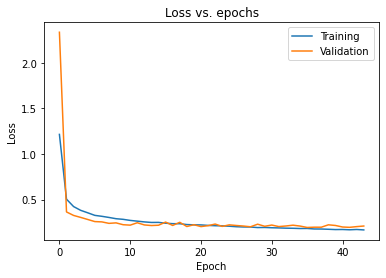

In [17]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

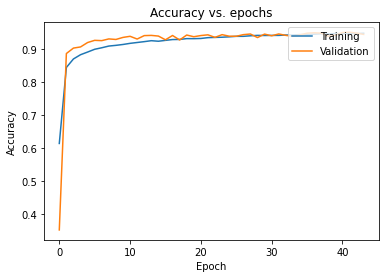

In [18]:
# Plot the training and validation loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [19]:
def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))
    print('loss: {los:0.3f}'.format(los=test_loss))

In [20]:
#Compute and display the loss and accuracy of the trained model on the test set.
get_test_accuracy(cnn_model,X_test_mlp,y_test)

accuracy: 0.950
loss: 0.198


## 4. Get model predictions
* Load the best weights for CNN model
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [21]:
#Load the best weights for the MLP and CNN models that you saved during the training run
cnn_model.load_weights('checkpoints_best_only_cnn/checkpoint')

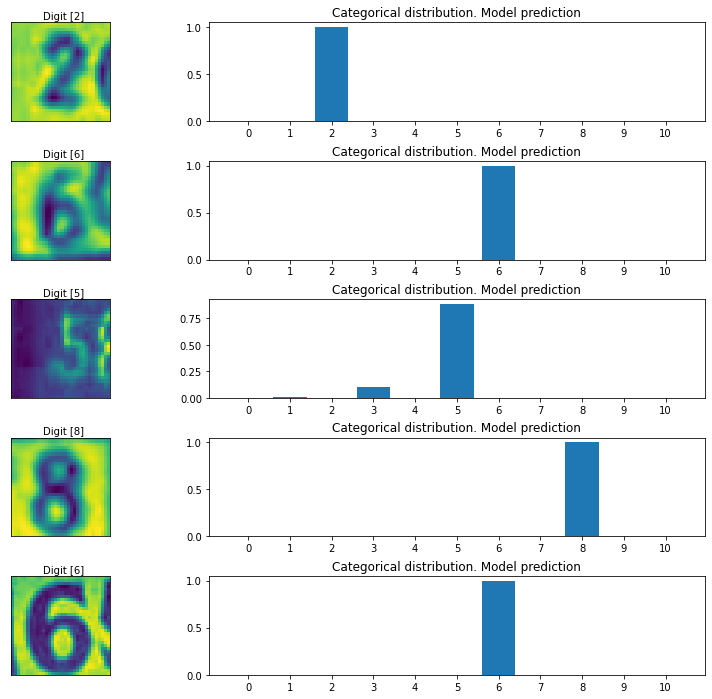

In [22]:
num_test_images = X_test_mlp.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = X_test_mlp[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions = cnn_model.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title("Categorical distribution. Model prediction")
    
plt.show()

**Clear Directories**

In [23]:
! rm -r checkpoints_best_only_cnn